In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import statsmodels.formula.api as smf
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential

In [ ]:
# download the global sustainable energy dataset from kaggle

import kagglehub

path = kagglehub.dataset_download("anshtanwar/global-data-on-sustainable-energy")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'global-data-on-sustainable-energy' dataset.
Path to dataset files: /kaggle/input/global-data-on-sustainable-energy


In [ ]:
# load dataset
energy = pd.read_csv('/kaggle/input/global-data-on-sustainable-energy/global-data-on-sustainable-energy (1).csv')
energy.head(10)

,Entity,Year,Access to electricity (% of population),Access to clean fuels for cooking,Renewable-electricity-generating-capacity-per-capita,Financial flows to developing countries (US $),Renewable energy share in the total final energy consumption (%),Electricity from fossil fuels (TWh),Electricity from nuclear (TWh),Electricity from renewables (TWh),...,Primary energy consumption per capita (kWh/person),Energy intensity level of primary energy (MJ/$2017 PPP GDP),Value_co2_emissions_kt_by_country,Renewables (% equivalent primary energy),gdp_growth,gdp_per_capita,Density\n(P/Km2),Land Area(Km2),Latitude,Longitude
0,Afghanistan,2000,1.613591,6.20,9.22,20000.0,44.99,0.16,0.0,0.31,...,302.59482,1.64,760.000000,NaN,NaN,NaN,60,652230.0,33.93911,67.709953
1,Afghanistan,2001,4.074574,7.20,8.86,130000.0,45.60,0.09,0.0,0.50,...,236.89185,1.74,730.000000,NaN,NaN,NaN,60,652230.0,33.93911,67.709953
2,Afghanistan,2002,9.409158,8.20,8.47,3950000.0,37.83,0.13,0.0,0.56,...,210.86215,1.40,1029.999971,NaN,NaN,179.426579,60,652230.0,33.93911,67.709953
3,Afghanistan,2003,14.738506,9.50,8.09,25970000.0,36.66,0.31,0.0,0.63,...,229.96822,1.40,1220.000029,NaN,8.832278,190.683814,60,652230.0,33.93911,67.709953
4,Afghanistan,2004,20.064968,10.90,7.75,NaN,44.24,0.33,0.0,0.56,...,204.23125,1.20,1029.999971,NaN,1.414118,211.382074,60,652230.0,33.93911,67.709953
5,Afghanistan,2005,25.390894,12.20,7.51,9830000.0,33.88,0.34,0.0,0.59,...,252.06912,1.41,1549.999952,NaN,11.229715,242.031313,60,652230.0,33.93911,67.709953
6,Afghanistan,2006,30.718690,13.85,7.40,10620000.0,31.89,0.20,0.0,0.64,...,304.42090,1.50,1759.999990,NaN,5.357403,263.733602,60,652230.0,33.93911,67.709953
7,Afghanistan,2007,36.051010,15.30,7.25,15750000.0,28.78,0.20,0.0,0.75,...,354.27990,1.53,1769.999981,NaN,13.826320,359.693158,60,652230.0,33.93911,67.709953
8,Afghanistan,2008,42.400000,16.70,7.49,16170000.0,21.17,0.19,0.0,0.54,...,607.83350,1.94,3559.999943,NaN,3.924984,364.663542,60,652230.0,33.93911,67.709953
9,Afghanistan,2009,46.740050,18.40,7.50,9960000.0,16.53,0.16,0.0,0.78,...,975.04816,2.25,4880.000114,NaN,21.390528,437.268740,60,652230.0,33.93911,67.709953


In [ ]:
energy.shape

(3649, 21)

In [ ]:
#Looking at missing values
print("Energy NA: ", energy["Entity"].isna().sum())
print("Year NA: ", energy["Year"].isna().sum())
print("Land Area NA: ", energy["Land Area(Km2)"].isna().sum())
print("Latitude NA: ", energy["Latitude"].isna().sum())
print("Longitude NA: ", energy["Longitude"].isna().sum())

#looking at where land area and latitude and longitude are missing
nan_rows = energy[energy['Land Area(Km2)'].isna()]
print(nan_rows)

print("French Guiana: ")
energy[energy["Entity"] == "French Guiana"]

#Removing French Guiana
energy = energy[energy["Entity"] != "French Guiana"]

Energy NA:  0
Year NA:  0
Land Area NA:  1
Latitude NA:  1
Longitude NA:  1
             Entity  Year  Access to electricity (% of population)  \
1218  French Guiana  2000                                      NaN   

      Access to clean fuels for cooking  \
1218                                NaN   

      Renewable-electricity-generating-capacity-per-capita  \
1218                                             702.29      

      Financial flows to developing countries (US $)  \
1218                                             NaN   

      Renewable energy share in the total final energy consumption (%)  \
1218                                              23.84                  

      Electricity from fossil fuels (TWh)  Electricity from nuclear (TWh)  \
1218                                 0.43                             0.0   

      Electricity from renewables (TWh)  ...  \
1218                                0.0  ...   

      Primary energy consumption per capita (kWh/person) 

##1. Using Regression to determine which countries will produce 50% of electricity from renewables by 2030.

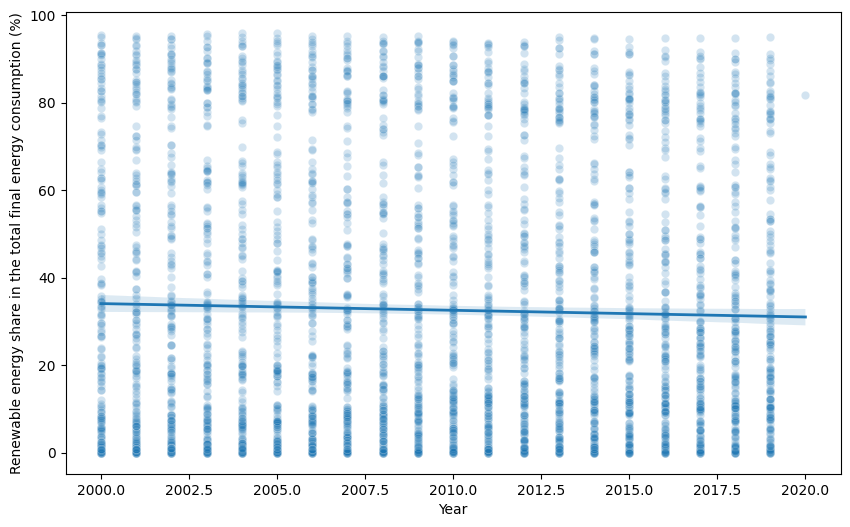

np.int64(194)

In [ ]:
#Regression data
regression_energy =  energy[["Entity", "Year", "Renewable energy share in the total final energy consumption (%)"]]

#data exploration plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data = regression_energy, x = "Year", y = "Renewable energy share in the total final energy consumption (%)", alpha = 0.2)
sns.regplot(data=regression_energy, x="Year", y="Renewable energy share in the total final energy consumption (%)", scatter=False, ci=95, line_kws={"linewidth": 2})
plt.show()


MAE: 25.500529814736037


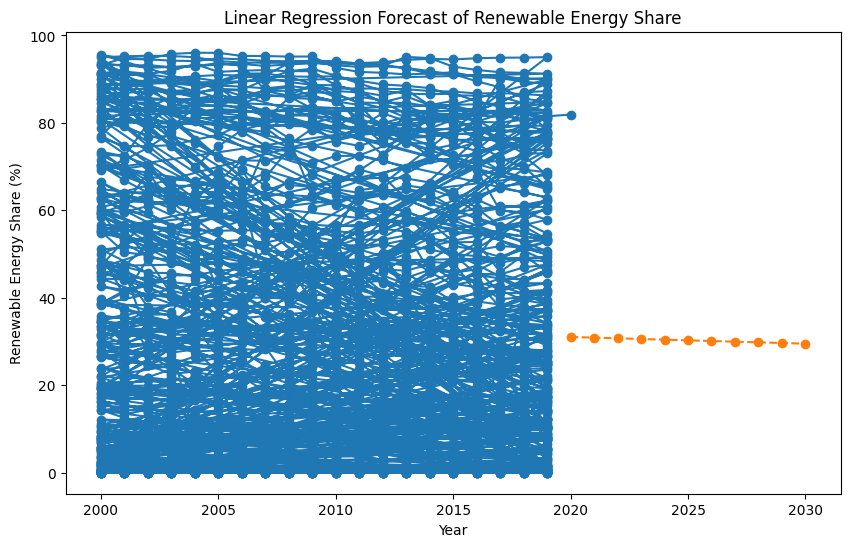

In [ ]:
#dropping na (~200 rows)
regression_energy = regression_energy.dropna()

#Seperating data for regression
X = regression_energy[['Year']].values
y = regression_energy['Renewable energy share in the total final energy consumption (%)'].values

tscv = TimeSeriesSplit(n_splits=5)

errors = []

#Running model
model = LinearRegression()

for train_idx, test_idx in tscv.split(X):
    model.fit(X[train_idx], y[train_idx])
    preds = model.predict(X[test_idx])
    errors.append(mean_absolute_error(y[test_idx], preds))

print("MAE:", np.mean(errors))

#Prediction
model.fit(X, y)
future_years = np.arange(2020, 2031).reshape(-1, 1)
future_preds = model.predict(future_years)

plt.figure(figsize=(10,6))

plt.scatter(X, y)
plt.plot(X, y)

plt.plot(future_years, future_preds, linestyle='--')
plt.scatter(future_years, future_preds)

plt.title("Linear Regression Forecast of Renewable Energy Share")
plt.xlabel("Year")
plt.ylabel("Renewable Energy Share (%)")

plt.show()

In [ ]:
# Scale Year
regression_energy["Year_c"] = regression_energy["Year"] - regression_energy["Year"].mean()

#Model
errors = []

for train_idx, test_idx in tscv.split(regression_energy):
    train = regression_energy.iloc[train_idx]
    test  = regression_energy.iloc[test_idx]

    model = smf.mixedlm(
        "Q('Renewable energy share in the total final energy consumption (%)') ~ Year_c",
        data=train,
        groups=train["Entity"],
        re_formula="~Year_c"
    ).fit(reml=False)

    preds = model.predict(test)

    re = model.random_effects
    for entity, eff in re.items():
        idx = test["Entity"] == entity
        intercept_re = eff.values[0]
        slope_re     = eff.values[1]
        preds[idx] += intercept_re + slope_re * test.loc[idx, "Year_c"]

    errors.append(mean_absolute_error(test["Renewable energy share in the total final energy consumption (%)"], preds))

print("Partial pooling MAE:", np.mean(errors))

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

Partial pooling MAE: 25.258881597005676


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

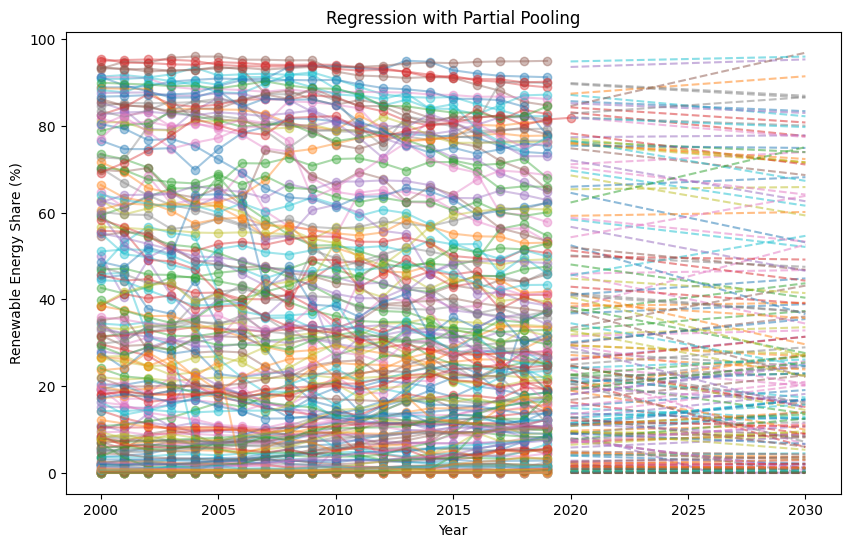

In [ ]:
# Prediction to 2030
regression_energy["Year_c"] = regression_energy["Year"] - regression_energy["Year"].mean()

#adding nonlinearity here for better results
regression_energy["Year_c2"] = regression_energy["Year_c"] ** 2

final_regression_model = smf.mixedlm(
    "Q('Renewable energy share in the total final energy consumption (%)') ~ Year_c",
    data=regression_energy,
    groups=regression_energy["Entity"],
    re_formula="~Year_c"
).fit(reml=False)

future = []
for entity in regression_energy["Entity"].unique():
    for year in range(2020, 2031):
        future.append({"Entity": entity, "Year": year})

future_df = pd.DataFrame(future)
future_df["Year_c"] = future_df["Year"] - regression_energy["Year"].mean()
future_df["Year_c2"] = future_df["Year_c"] ** 2

future_df["Prediction"] = final_regression_model.predict(future_df)

re = model.random_effects
for entity, eff in final_regression_model.random_effects.items():
    idx = future_df["Entity"] == entity
    intercept_re = eff["Group"]
    slope_re = eff["Year_c"]
    future_df.loc[idx, "Prediction"] += intercept_re + slope_re * future_df.loc[idx, "Year_c"]

#Clipping values to stay above 0
future_df["Prediction"] = future_df["Prediction"].clip(lower=0)

# Plotting
plt.figure(figsize=(10,6))

for entity, group in regression_energy.groupby("Entity"):
    plt.scatter(group["Year"], group["Renewable energy share in the total final energy consumption (%)"], alpha=0.4)
    plt.plot(group["Year"], group["Renewable energy share in the total final energy consumption (%)"], alpha=0.4)

for entity, group in future_df.groupby("Entity"):
    plt.plot(group["Year"], group["Prediction"], linestyle="--", alpha=0.5)

plt.title("Regression with Partial Pooling")
plt.xlabel("Year")
plt.ylabel("Renewable Energy Share (%)")
plt.show()

Entity        40
Year          40
Year_c        40
Year_c2       40
Prediction    40
dtype: int64
Countries expected to exceed 50% renewable energy share by 2030:
['Bhutan', 'Burkina Faso', 'Burundi', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Congo', 'Denmark', 'Eritrea', 'Eswatini', 'Ethiopia', 'Finland', 'Gabon', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Haiti', 'Iceland', 'Kenya', 'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Mozambique', 'Myanmar', 'Nepal', 'Niger', 'Nigeria', 'Norway', 'Paraguay', 'Rwanda', 'Sierra Leone', 'Somalia', 'Sweden', 'Togo', 'Uganda', 'Uruguay', 'Zambia', 'Zimbabwe']
Countries predicted to pass 50% by 2030 (were below 50% in 2019):
     Entity  Renewable energy share in the total final energy consumption (%)  \
42  Denmark                                              37.52                  
55  Finland                                              45.76                  

    Prediction  
42   52.630769  
55   54.648569  
Countries predicte

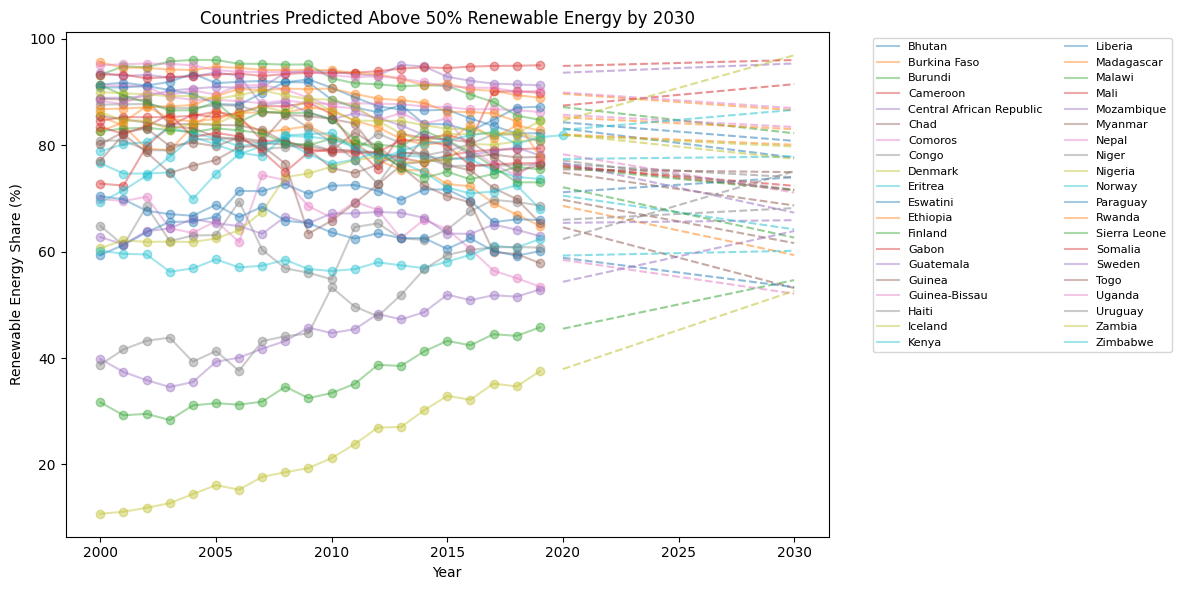

In [ ]:
#Results
energy_percent_2030 = future_df[future_df["Year"] == 2030]
energy_percent_2019 = regression_energy[regression_energy["Year"] == 2019]

#Above 50%
above_50 = energy_percent_2030[energy_percent_2030["Prediction"] > 50]
print(above_50.count())
print("Countries expected to exceed 50% renewable energy share by 2030:")
print(above_50["Entity"].tolist())

#Passed 50%
merged = pd.merge(
    energy_percent_2030[["Entity", "Prediction"]],
    energy_percent_2019[["Entity", "Renewable energy share in the total final energy consumption (%)"]],
    on="Entity",
    how="left"
)

passed_50 = merged[
    (merged["Renewable energy share in the total final energy consumption (%)"] < 50) &
    (merged["Prediction"] > 50)
]

print("Countries predicted to pass 50% by 2030 (were below 50% in 2019):")
print(passed_50[["Entity", "Renewable energy share in the total final energy consumption (%)", "Prediction"]])

#Sank below 50%
sank_50 = merged[
    (merged["Renewable energy share in the total final energy consumption (%)"] > 50) &
    (merged["Prediction"] < 50)
]

print("Countries predicted to sink below 50% by 2030:")
print(sank_50[["Entity", "Renewable energy share in the total final energy consumption (%)", "Prediction"]])

print("")
print("China: ")
print(regression_energy[regression_energy["Entity"] == "China"])
print(future_df[future_df["Entity"] == "China"])

#Plotting
above_50_entities = above_50["Entity"].tolist()

plt.figure(figsize=(12,6))

lines = []
labels = []

for entity in above_50_entities:
    hist = regression_energy[regression_energy["Entity"] == entity]
    plt.scatter(hist["Year"], hist["Renewable energy share in the total final energy consumption (%)"], alpha=0.4)
    line, = plt.plot(hist["Year"], hist["Renewable energy share in the total final energy consumption (%)"], alpha=0.4)
    lines.append(line)
    labels.append(entity)

for entity in above_50_entities:
    pred = future_df[future_df["Entity"] == entity]
    plt.plot(pred["Year"], pred["Prediction"], linestyle="--", alpha=0.5)

plt.legend(lines, labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, ncol=2)

plt.title("Countries Predicted Above 50% Renewable Energy by 2030")
plt.xlabel("Year")
plt.ylabel("Renewable Energy Share (%)")
plt.tight_layout()
plt.show()

##Use a denoising autoencoder to help fill missing data

In [ ]:
#Prepping data for DAE
numeric_cols = energy.select_dtypes(include=['number']).columns
energy_filled = energy.copy()

#fill with entity-specific mean
energy_filled[numeric_cols] = energy_filled.groupby('Entity')[numeric_cols].transform(
    lambda x: x.fillna(x.mean())
).fillna(energy_filled[numeric_cols].mean())

mask = (~energy[numeric_cols].isna()).astype(np.float32).values
mask_float = mask.astype(np.float32)

scaler = StandardScaler()
energy_scaled = scaler.fit_transform(energy_filled[numeric_cols])

#adding noise with a factor of .2
noise = np.random.normal(loc=0.0, scale=0.2, size=energy_scaled.shape)
energy_noisy = energy_scaled + (noise * mask)

In [ ]:
#DAE
input_dimension = energy_scaled.shape[1]

model = Sequential()

#Encoder
model.add(layers.Dense(512, activation='relu', input_shape=(input_dimension,)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

# Bottleneck
model.add(layers.Dense(48, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

#Decoder
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

# Output layer
model.add(layers.Dense(input_dimension, activation='linear'))

#fixing data dimensions
y_true = np.concatenate([energy_scaled, mask], axis=1)

#Computing MSE only on non-masked data
def masked_mse(y_true, y_pred):
    F = tf.shape(y_pred)[1]

    X_true = y_true[:, :F]
    M      = y_true[:, F:]

    return tf.reduce_mean(M * tf.square(X_true - y_pred))

#Computing MAE only on non-masked data
def masked_mae(y_true, y_pred):
    F = y_pred.shape[1]
    X_true = y_true[:, :F]
    M = y_true[:, F:]
    return tf.reduce_mean(M * tf.abs(X_true - y_pred))

#Exponential decay learning rate
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    0.001,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True
)

# Compile
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=masked_mse,
    metrics=[masked_mae]
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Training DAE

model.fit(
    energy_noisy,
    np.concatenate([energy_scaled, mask], axis=1),
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(
            patience=55,
            restore_best_weights=True,
            monitor='val_loss'
        )
    ]
)

Epoch 1/150
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1980 - masked_mae: 0.2899 - val_loss: 0.1943 - val_masked_mae: 0.2437
Epoch 2/150
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.2001 - masked_mae: 0.2874 - val_loss: 0.6644 - val_masked_mae: 0.2742
Epoch 3/150
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1940 - masked_mae: 0.2856 - val_loss: 0.3267 - val_masked_mae: 0.2510
Epoch 4/150
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1977 - masked_mae: 0.2867 - val_loss: 0.3515 - val_masked_mae: 0.2522
Epoch 5/150
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2021 - masked_mae: 0.2871 - val_loss: 0.2923 - val_masked_mae: 0.2537
Epoch 6/150
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1871 - masked_mae: 0.2826 - val_loss: 0.4714 - val_masked_mae: 0.2547
Epoch 7/150
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.1881 - masked_mae: 0.2840 - val_loss: 0.8415 - val_masked_mae: 0.2786
Epoch 8/150
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.1904 - masked_

In [ ]:
#Prediction
reconstructed = model.predict(energy_scaled)
energy_imputed = energy_scaled * mask + reconstructed * (1 - mask)
energy_imputed_original = scaler.inverse_transform(energy_imputed)

#Converting data back
energy_imputed_df = pd.DataFrame(
    scaler.inverse_transform(energy_imputed),
    columns=numeric_cols,
    index=energy.index
)

for col in numeric_cols:
    energy_imputed_df[col] = energy_imputed_df[col].astype(energy[col].dtype)

energy_final = energy.copy()
energy_final[numeric_cols] = energy_imputed_df

pd.set_option('display.float_format', lambda x: f'{x:.2f}')
energy_final.head(10)

114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


,Entity,Year,Access to electricity (% of population),Access to clean fuels for cooking,Renewable-electricity-generating-capacity-per-capita,Financial flows to developing countries (US $),Renewable energy share in the total final energy consumption (%),Electricity from fossil fuels (TWh),Electricity from nuclear (TWh),Electricity from renewables (TWh),...,Primary energy consumption per capita (kWh/person),Energy intensity level of primary energy (MJ/$2017 PPP GDP),Value_co2_emissions_kt_by_country,Renewables (% equivalent primary energy),gdp_growth,gdp_per_capita,Density\n(P/Km2),Land Area(Km2),Latitude,Longitude
0,Afghanistan,2000,1.61,6.20,9.22,20000.00,44.99,0.16,0.00,0.31,...,302.59,1.64,760.00,11.90,3.36,13610.26,60,652230.00,33.94,67.71
1,Afghanistan,2001,4.07,7.20,8.86,130000.00,45.60,0.09,0.00,0.50,...,236.89,1.74,730.00,11.93,3.38,13591.22,60,652230.00,33.94,67.71
2,Afghanistan,2002,9.41,8.20,8.47,3950000.00,37.83,0.13,0.00,0.56,...,210.86,1.40,1030.00,11.96,3.39,179.43,60,652230.00,33.94,67.71
3,Afghanistan,2003,14.74,9.50,8.09,25970000.00,36.66,0.31,0.00,0.63,...,229.97,1.40,1220.00,11.99,8.83,190.68,60,652230.00,33.94,67.71
4,Afghanistan,2004,20.06,10.90,7.75,75833054.78,44.24,0.33,0.00,0.56,...,204.23,1.20,1030.00,12.01,1.41,211.38,60,652230.00,33.94,67.71
5,Afghanistan,2005,25.39,12.20,7.51,9830000.00,33.88,0.34,0.00,0.59,...,252.07,1.41,1550.00,12.07,11.23,242.03,60,652230.00,33.94,67.71
6,Afghanistan,2006,30.72,13.85,7.40,10620000.00,31.89,0.20,0.00,0.64,...,304.42,1.50,1760.00,12.05,5.36,263.73,60,652230.00,33.94,67.71
7,Afghanistan,2007,36.05,15.30,7.25,15750000.00,28.78,0.20,0.00,0.75,...,354.28,1.53,1770.00,12.08,13.83,359.69,60,652230.00,33.94,67.71
8,Afghanistan,2008,42.40,16.70,7.49,16170000.00,21.17,0.19,0.00,0.54,...,607.83,1.94,3560.00,12.10,3.92,364.66,60,652230.00,33.94,67.71
9,Afghanistan,2009,46.74,18.40,7.50,9960000.00,16.53,0.16,0.00,0.78,...,975.05,2.25,4880.00,12.13,21.39,437.27,60,652230.00,33.94,67.71


##2. Identify countries where renewable energy adoption is most effective in cutting co2 emissions

In [ ]:
# calculate the year-to-year changes in renewable energy per country
energy_final['renewable_percent_change'] = energy_final.groupby('Entity')['Renewable energy share in the total final energy consumption (%)'].diff()
# calculate the year-to-year changes in co2 emissions per country
energy_final['co2_emissions_change'] = energy_final.groupby('Entity')['Value_co2_emissions_kt_by_country'].diff()

In [ ]:
# clean any infinite values
energy_final = energy_final.replace([np.inf, -np.inf], np.nan)
energy_final = energy_final.dropna(subset=["renewable_percent_change", "co2_emissions_change"])

# remove small changes
energy_final = energy_final[energy_final['renewable_percent_change'].abs() > 0.3]

In [ ]:
# measure the level of effectiveness of the year-to-year changes:
# for every increase in renewable share, how much did co2 drop?
energy_final['effectiveness_raw'] = np.where(
    energy_final['renewable_percent_change'] == 0,
    np.nan,
    -energy_final['co2_emissions_change'] / energy_final['renewable_percent_change']
)

In [ ]:
# smooth
energy_final["effectiveness_smoothed"] = (
    energy_final.groupby("Entity")["effectiveness_raw"]
    .transform(lambda x: x.rolling(3, min_periods=1).mean())
)

In [ ]:
# clean any infinite values
energy_final['effectiveness_smoothed'] = energy_final['effectiveness_smoothed'].replace([np.inf, -np.inf], np.nan)
energy_final = energy_final.dropna(subset=["effectiveness_smoothed"])

In [ ]:
# remove extreme outliers
Q1 = energy_final['effectiveness_smoothed'].quantile(0.01)
Q3 = energy_final['effectiveness_smoothed'].quantile(0.99)
energy_final = energy_final[energy_final['effectiveness_smoothed'].between(Q1, Q3)]

In [ ]:
energy_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2693 entries, 5 to 3648
Data columns (total 24 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   Entity                                                            2693 non-null   object 
 1   Year                                                              2693 non-null   int64  
 2   Access to electricity (% of population)                           2693 non-null   float64
 3   Access to clean fuels for cooking                                 2693 non-null   float64
 4   Renewable-electricity-generating-capacity-per-capita              2693 non-null   float64
 5   Financial flows to developing countries (US $)                    2693 non-null   float64
 6   Renewable energy share in the total final energy consumption (%)  2693 non-null   float64
 7   Electricity from fossil fuels (TWh)   

In [ ]:
# rename density
energy_final.rename(columns={"Density\\n(P/Km2)": "Density (P/Km2)"}, inplace=True)
energy_final["Density (P/Km2)"] = (
    energy_final["Density (P/Km2)"]
    .astype(str)
    .str.replace(",", "")
    .astype(float)
)

In [ ]:
# set predictors for model
predictors = [
    "gdp_per_capita",
    "Energy intensity level of primary energy (MJ/$2017 PPP GDP)",
    "Primary energy consumption per capita (kWh/person)",
    "Density (P/Km2)",
    "Access to electricity (% of population)",
    "Renewable-electricity-generating-capacity-per-capita",
    "Electricity from renewables (TWh)",
    "Low-carbon electricity (% electricity)",
    "Renewable energy share in the total final energy consumption (%)",
]

# define X and y values
X = energy_final[predictors]
y = energy_final["effectiveness_smoothed"]

In [ ]:
# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# build random forest model
rf = RandomForestRegressor(
    n_estimators=1000, # number of trees
    min_samples_leaf=5,
    random_state=42
)

# train random forest regressor
rf.fit(X_train_scaled, y_train)

# make predictions on test set
y_pred = rf.predict(X_test_scaled)

# calculate mse and r^2 score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Mean Squared Error: 2249979.0828297795
R^2 Score: 0.48301857477326615


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# build a gradient boosting model
gb = GradientBoostingRegressor(
    n_estimators=500, # number of trees
    learning_rate=0.05,
    min_samples_leaf=5,
    random_state=42
)

# fit the model to train data
gb.fit(X_train, y_train)

# make predictions on test set
y_pred = gb.predict(X_test)

# calculate mse and r^2 score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Mean Squared Error: 40416479.12805108
R^2 Score: 0.38020441831531293


In [ ]:
# aggregate predictions by country so we have one effectiveness score per country
# scale X for predictions
X_scaled = scaler.transform(X)
energy_final['predicted_effectiveness'] = rf.predict(X_scaled)

# aggregate by country
country_effectiveness_pred = energy_final.groupby('Entity')['predicted_effectiveness'].mean().reset_index()
country_effectiveness_pred = country_effectiveness_pred.sort_values('predicted_effectiveness', ascending=False)

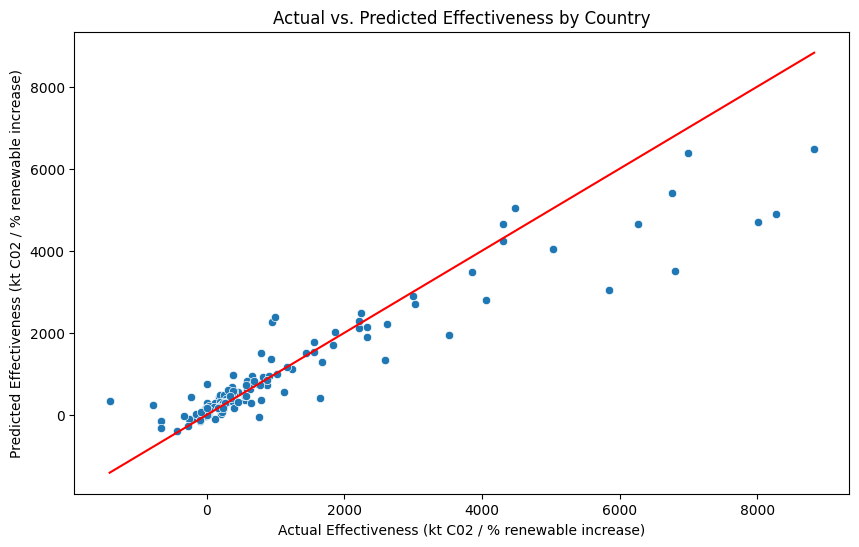

In [ ]:
# make a scatterplot to visualize predicted vs actual effectiveness values by country
plot_data = energy_final.groupby('Entity')[['effectiveness_smoothed', 'predicted_effectiveness']].mean().reset_index()

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=plot_data,
    x='effectiveness_smoothed',
    y='predicted_effectiveness'
)
# add diagonal line y=x to indicate the actual effectiveness
max_val = max(plot_data['effectiveness_smoothed'].max(), plot_data['predicted_effectiveness'].max())
min_val = min(plot_data['effectiveness_smoothed'].min(), plot_data['predicted_effectiveness'].min())
plt.plot([min_val, max_val], [min_val, max_val], color='red')

plt.xlabel('Actual Effectiveness (kt C02 / % renewable increase)')
plt.ylabel('Predicted Effectiveness (kt C02 / % renewable increase)')
plt.title('Actual vs. Predicted Effectiveness by Country')
plt.show()

In [ ]:
# identify top 10 countries with highest predicted effectiveness to benefit most
# from renewable energy adoption in reducing CO2
top_countries = country_effectiveness_pred.head(10)
print(top_countries)

             Entity  predicted_effectiveness
61            Italy                  6474.25
58        Indonesia                  6393.54
115           Spain                  5410.70
100          Poland                  5049.33
127  United Kingdom                  4902.21
122        Thailand                  4702.95
86      Netherlands                  4660.89
46          Germany                  4645.48
99      Philippines                  4241.25
91          Nigeria                  4031.93


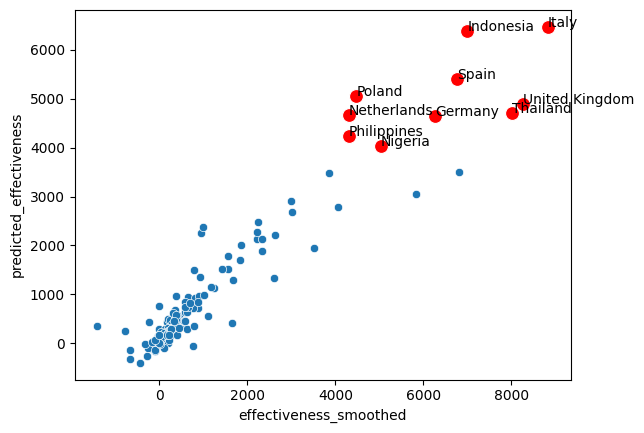

In [ ]:
# make a scatterplot that highlights the top 10 countries to visualize where they stand
top10 = plot_data.nlargest(10, 'predicted_effectiveness') # take the top 10 from y

sns.scatterplot(data=plot_data, x='effectiveness_smoothed', y='predicted_effectiveness')
# highlight the top 10 countries data points in red on the scatterplot
sns.scatterplot(data=top10, x='effectiveness_smoothed', y='predicted_effectiveness', color='red', s=100)

# label the points with the entity name
for i, row in top10.iterrows():
    plt.text(row['effectiveness_smoothed'], row['predicted_effectiveness'], row['Entity'])

In [ ]:
# calculate tree-based feature importance to determine which variables have the highest impact on predicting effectiveness
importance = pd.DataFrame({
    'feature': predictors,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)
print(importance)

                                             feature  importance
6                  Electricity from renewables (TWh)        0.31
7             Low-carbon electricity (% electricity)        0.19
5  Renewable-electricity-generating-capacity-per-...        0.14
8  Renewable energy share in the total final ener...        0.10
3                                    Density (P/Km2)        0.07
2  Primary energy consumption per capita (kWh/per...        0.07
1  Energy intensity level of primary energy (MJ/$...        0.06
0                                     gdp_per_capita        0.05
4            Access to electricity (% of population)        0.02
